# init

In [1]:
# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# to be able to use python files
import sys 
sys.path.append('pyfiles/')
import classes as cl
# This reloads external modules every time a cell is run
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2
import csv #for loading function

# input shape

### parametric eq for ellipse: 
$F(t) = (x(t), y(t))$, where $x(t) = a*cos(t)$ and $y(t) = b*sin(t)$

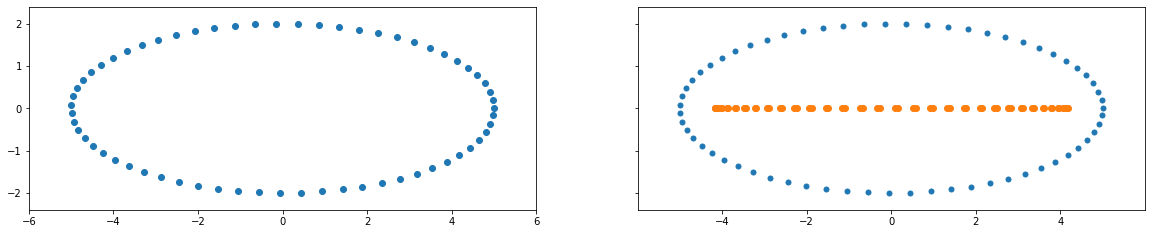

In [2]:
# parameters for ellipse shape and sampling density
a = 5
b = 2

# c is sampling density: smaller is more dense
c = .01
c = 1
t = np.arange(0.0, 6.28, c/10)
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)
x = a*np.cos(t)
y = b*np.sin(t)
points = np.array(list(zip(x,y)))
vor = Voronoi(points)

# plot ellipse
ax1.set_xlim(-(max(a,b) + 1), (max(a,b) + 1))
ax1.set_ylim(-(max(a,b) + 1), (max(a,b) + 1))
ax1.set_aspect('equal')
ax1.plot(x,y,'o')

# plot voronoi stuff
ax2.set_xlim(-(max(a,b) + 1), (max(a,b) + 1))
ax2.set_ylim(-(max(a,b) + 1), (max(a,b) + 1))
ax2.set_aspect('equal')
voronoi_plot_2d(vor, ax2, show_vertices=True, line_alpha = 0, show_points = True, point_colors='orange', point_size=10)

fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()

# turn points into simplices and add connecting edges 

In [3]:
init_complex = cl.complex()
i = 0
# we give the complex vertices
for point in points:
    temp_simplex = cl.simplex()
    temp_simplex.coords = [round(point[0],2), round(point[1],2)]
    temp_simplex.index = i
    temp_simplex.dim = 0
    temp_simplex.boundary = [-1]
    i += 1
    init_complex.vertlist.append(temp_simplex)
    init_complex.nverts += 1


complexx = deepcopy(init_complex)

# add edges to complexx
for i in range(len(init_complex.vertlist)):
    temp_edge = cl.simplex()
    temp_edge.boundary = [i, (i + 1)%(len(init_complex.vertlist))]
    temp_edge.dim = 1
    temp_edge.index = i + 1 # maybe this makes no sense
    complexx.edgelist.append(temp_edge)
    complexx.nedges += 1
    i += 1

print(complexx)
print(init_complex)

number of verts is 63, and number of edges is 63
number of verts is 63, and number of edges is 0


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


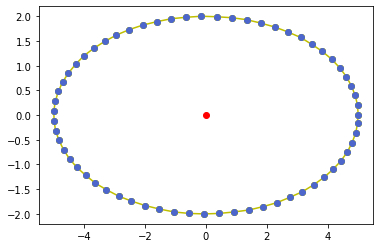

In [4]:
complexx.plot()

# use distance from special point to create ordering on all simplices 
note: maybe don't start with point on curve

In [5]:
#repeating because maybe we can just do this at the same time

orderedcplx = deepcopy(cl.complex())
# the key point is the one we will take the squared dist from
orderedcplx.key_point = init_complex.vertlist[0].coords
orderedcplx.key_point = (0,0)
distlist = []
# find distance-squareds
for i in range(len(init_complex.vertlist)):
    temp_simplex = init_complex.vertlist[i]
    dist = distance.euclidean(orderedcplx.key_point, temp_simplex.coords)
    distsq = round(dist*dist,2)
    temp_simplex.radialdist = distsq
    distlist.append(distsq)
    # reset the index
#     temp_simplex.index = -1
    temp_simplex.index = i
    orderedcplx.vertlist.append(temp_simplex)
    orderedcplx.nverts += 1
    i += 1
# orderedcplx.vertlist
print(distlist)
# at this point, orderedcplx has the verts, and they each have .radialdist as their di

[25.0, 24.84, 24.17, 23.2, 21.86, 20.19, 18.33, 16.26, 14.16, 12.14, 10.11, 8.32, 6.74, 5.52, 4.6, 4.08, 4.02, 4.33, 5.1, 6.2, 7.64, 9.34, 11.27, 13.31, 15.44, 17.52, 19.38, 21.15, 22.63, 23.75, 24.58, 25.01, 24.91, 24.51, 23.59, 22.39, 20.86, 19.1, 17.09, 15.08, 12.97, 10.93, 9.03, 7.35, 5.98, 4.94, 4.27, 4.0, 4.15, 4.71, 5.7, 6.99, 8.61, 10.43, 12.45, 14.52, 16.64, 18.6, 20.49, 22.09, 23.35, 24.34, 24.83]


In [6]:
# sorts by distlist[ind] but in case of tie, ind breaks tie
# "" sorts by radius, but then uses input index to consistently break ties

# I think we have to make a new list here
old_indices = []
for i in range(len(orderedcplx.vertlist)):
    old_indices.append(orderedcplx.vertlist[i].index)
    
for new_i, i in enumerate(sorted(old_indices, key = lambda ind: (distlist[ind], ind))):
    orderedcplx.vertlist[i].orderedindex = new_i
    
orderedcplx.print_inds()


63  indices
orig  0  new:  61
orig  1  new:  59
orig  2  new:  54
orig  3  new:  50
orig  4  new:  46
orig  5  new:  42
orig  6  new:  38
orig  7  new:  34
orig  8  new:  30
orig  9  new:  26
orig  10  new:  22
orig  11  new:  18
orig  12  new:  14
orig  13  new:  10
orig  14  new:  6
orig  15  new:  2
orig  16  new:  1
orig  17  new:  5
orig  18  new:  9
orig  19  new:  13
orig  20  new:  17
orig  21  new:  21
orig  22  new:  25
orig  23  new:  29
orig  24  new:  33
orig  25  new:  37
orig  26  new:  41
orig  27  new:  45
orig  28  new:  49
orig  29  new:  53
orig  30  new:  57
orig  31  new:  62
orig  32  new:  60
orig  33  new:  56
orig  34  new:  52
orig  35  new:  48
orig  36  new:  44
orig  37  new:  40
orig  38  new:  36
orig  39  new:  32
orig  40  new:  28
orig  41  new:  24
orig  42  new:  20
orig  43  new:  16
orig  44  new:  12
orig  45  new:  8
orig  46  new:  4
orig  47  new:  0
orig  48  new:  3
orig  49  new:  7
orig  50  new:  11
orig  51  new:  15
orig  52  new:  19
o

# sort the verts

In [7]:
# # not actual code
# for new_i, i in enumerate(thatlist):
#     simplex[i].orderedindex = new_i
    
# # still not actual code
# for new_i, i in enumerate(sorted(orig, key= lambda ind: distlist[ind])):
#     simplex[i].orderedindex = new_i

# # still still not actual code
# sorts by distlist[ind] but in case of tie, ind breaks tie
# "" sorts by radius, but then uses input index to consistently break ties
# for new_i, i in enumerate(sorted(orig, key= lambda ind: (distlist[ind], ind))):
#     simplex[i].orderedindex = new_i

# if column is repr as set of indices, max yields lowest one
# max can (maybe) be re-keyed to return max wrt ie radius instead of index
# max(column, key=...), key as lambda funcion like for enumerate


In [8]:
# sorted(orig, key= lambda ind: distlist[ind])

[25.0, 24.84, 24.17, 23.2, 21.86, 20.19, 18.33, 16.26, 14.16, 12.14, 10.11, 8.32, 6.74, 5.52, 4.6, 4.08, 4.02, 4.33, 5.1, 6.2, 7.64, 9.34, 11.27, 13.31, 15.44, 17.52, 19.38, 21.15, 22.63, 23.75, 24.58, 25.01, 24.91, 24.51, 23.59, 22.39, 20.86, 19.1, 17.09, 15.08, 12.97, 10.93, 9.03, 7.35, 5.98, 4.94, 4.27, 4.0, 4.15, 4.71, 5.7, 6.99, 8.61, 10.43, 12.45, 14.52, 16.64, 18.6, 20.49, 22.09, 23.35, 24.34, 24.83]


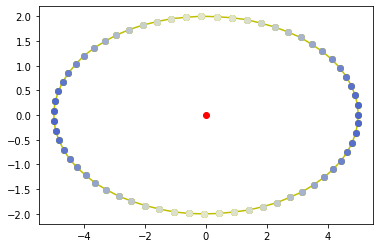

In [9]:
# add unordered edges
# add edges to complexx
for i in range(len(orderedcplx.vertlist)):
    temp_edge = cl.simplex()
    temp_edge.boundary = [i, (i + 1)%(len(init_complex.vertlist))]
    temp_edge.dim = 1
    temp_edge.index = i + 1 # maybe this makes no sense
    orderedcplx.edgelist.append(temp_edge)
    orderedcplx.nedges += 1
    i += 1
orderedcplx.plot()
# print([v.index for v in orderedcplx.vertlist])

## next: use ordering obtained sorting via distance func to make matrix

## note to self: at this point, edges are not entered in new ordered complex

# misc

In [10]:
[i*3 for i in range(5)]

[0, 3, 6, 9, 12]

In [11]:
list(i*3 for i in range(5))

[0, 3, 6, 9, 12]

In [12]:
[i**2 for i in range(-5,6)]

[25, 16, 9, 4, 1, 0, 1, 4, 9, 16, 25]

In [13]:
{i**2 for i in range(-5,6)}

{0, 1, 4, 9, 16, 25}

In [14]:
{ key : value for key, value in enumerate(['first','second','third'])}

{0: 'first', 1: 'second', 2: 'third'}

In [15]:
(lambda a: a+2)(5)

7